In [44]:
import torch
import torch.nn as nn
import torchvision.datasets as datsets
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

In [46]:
dataset_address = "data"
workers = 2

batch_size = 128
image_size = 64


nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5

In [47]:
trans = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5))
])

dataset = datsets.ImageFolder(dataset_address , transform=trans)

data_loader = DataLoader(dataset,batch_size=batch_size , num_workers=workers , shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

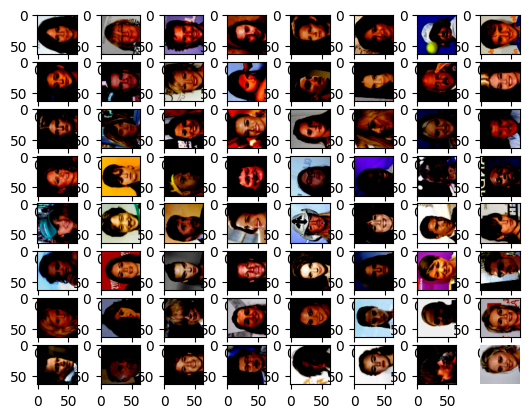

In [48]:
example_data = next(iter(data_loader))

for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(np.transpose(example_data[0][i].numpy()))

plt.axis("off")
plt.savefig("outputs/example data.png")
plt.show()

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [67]:
class Generator(nn.Module):
    def __init__(self , num_z , num_feature , num_chanels):
        super(Generator,self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(num_z , num_feature*8 , 4,1,0, bias=False),
            nn.BatchNorm2d(num_feature*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature*8 , num_feature*4 , 4,2,1, bias=False),
            nn.BatchNorm2d(num_feature*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature*4 , num_feature*2 , 4,2,1, bias=False),
            nn.BatchNorm2d(num_feature*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature*2 , num_feature , 4,2,1, bias=False),
            nn.BatchNorm2d(num_feature),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature , num_chanels , 4,2,1, bias=False),
            nn.Tanh()
        )

    def forward(self , x):
        return self.net(x)

In [51]:
class Discriminator(nn.Module):
    def __init__(self,number_of_chanels , num_features):
        super(Discriminator , self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(number_of_chanels , num_features , 4,2,1 , bias=False),
            nn.LeakyReLU(0.2 , inplace=True),
            
            nn.Conv2d(num_features , num_features*2,4,2,1, bias=False),
            nn.BatchNorm2d(num_features*2),
            nn.LeakyReLU(0.2 , inplace=True),

            nn.Conv2d(num_features*2 , num_features*4,4,2,1, bias=False),
            nn.BatchNorm2d(num_features*4),
            nn.LeakyReLU(0.2 , inplace=True),

            nn.Conv2d(num_features*4 , num_features*8,4,2,1, bias=False),
            nn.BatchNorm2d(num_features*8),
            nn.LeakyReLU(0.2 , inplace=True),

            nn.Conv2d(num_features*8 ,1,4,1,0, bias=False),
            
            nn.Sigmoid()

        )
        
    def forward(self, x):
        return self.net(x)

In [68]:
netG = Generator(nz,ngf,nc)

netD = Discriminator(nc , ndf )


In [69]:
netD = netD.to(device)
netG = netG.to(device)

In [70]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

test_input = torch.randn(64 , nz ,1,1 ).to(device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.001)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.001)

In [71]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(test_input).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.6196	Loss_G: 8.3178	D(x): 0.4075	D(G(z)): 0.4965 / 0.0003
[0/5][50/1583]	Loss_D: 0.1346	Loss_G: 10.3787	D(x): 0.9609	D(G(z)): 0.0467 / 0.0001
[0/5][100/1583]	Loss_D: 0.0050	Loss_G: 12.8615	D(x): 0.9991	D(G(z)): 0.0041 / 0.0000
[0/5][150/1583]	Loss_D: 0.0490	Loss_G: 8.5406	D(x): 0.9797	D(G(z)): 0.0068 / 0.0003
[0/5][200/1583]	Loss_D: 0.0023	Loss_G: 11.3047	D(x): 0.9989	D(G(z)): 0.0012 / 0.0000
[0/5][250/1583]	Loss_D: 0.0955	Loss_G: 16.5720	D(x): 0.9998	D(G(z)): 0.0476 / 0.0000
[0/5][300/1583]	Loss_D: 0.0078	Loss_G: 14.4703	D(x): 0.9940	D(G(z)): 0.0006 / 0.0000
[0/5][350/1583]	Loss_D: 0.0416	Loss_G: 12.8190	D(x): 0.9909	D(G(z)): 0.0291 / 0.0000
